In [77]:
import pandas as pd
import gensim
import nltk
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

%matplotlib inline

nltk.download('wordnet')

# download word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# filename = 'abcnews-date-text.csv'
filename = 'twitter_trump_2019_05.csv'
raw_docs = pd.read_csv(filename, error_bad_lines=False)

In [5]:
len(raw_docs)

677

In [6]:
raw_docs.head()

,text,created_at,id_str
0,Robert Mueller came to the Oval Office (along ...,05-30-2019 15:34:11,1134120831389392896
1,“Comey and Brennan are turning on each other.”...,05-30-2019 14:41:24,1134107544681455616
2,Congressman John Ratcliffe “The Trump Campaign...,05-30-2019 13:41:43,1134092525218590721
3,Russia Russia Russia! That’s all you heard at ...,05-30-2019 11:57:47,1134066371510378501
4,....say he fought back against this phony crim...,05-30-2019 11:57:47,1134066372584062976


In [7]:
raw_docs['text'][:10]

0    Robert Mueller came to the Oval Office (along ...
1    “Comey and Brennan are turning on each other.”...
2    Congressman John Ratcliffe “The Trump Campaign...
3    Russia Russia Russia! That’s all you heard at ...
4    ....say he fought back against this phony crim...
5    Russia Russia Russia! That’s all you heard at ...
6    ....say he fought back against this phony crim...
7    The Greatest Presidential Harassment in histor...
8    I was not informed about anything having to do...
9    Great show tonight @seanhannity you really get...
Name: text, dtype: object

In [8]:
import pdb

def preprocess_docs(raw_docs, num_docs=None):
    """
    Args:
        raw_docs: pandas.DataFrame

    Returns:
        list(list): return list of list
    """
    if num_docs is None:
        num_docs = len(raw_docs)
        
    docs = list()

    stemmer = nltk.stem.SnowballStemmer('english')
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    
    stopwords_http = ['https', 'rt', 'amp']

    for d in raw_docs['text'][:num_docs]:
        
#         print(d)
        processed_tokens = list()
        # normalize and tokenize
        tokens = gensim.utils.simple_preprocess(d)
    
#         print(tokens)
#         pdb.set_trace()

        # lemmatize then stem
        for t in tokens:
            # remove stop words
            if t not in gensim.parsing.preprocessing.STOPWORDS:
                if t not in stopwords_http:
    #             print(t)
                    p_t = stemmer.stem(lemmatizer.lemmatize(t, pos='v'))
                    processed_tokens.append(p_t)
            
    #             pdb.set_trace()

        docs.append(processed_tokens)
    
    return docs


docs = preprocess_docs(raw_docs)

In [9]:
print(len(docs))
# print(docs)

677


In [10]:
def create_dictionary(docs):
    return gensim.corpora.Dictionary(docs)

dictionary = create_dictionary(docs)

## Function to recover stem

In [11]:
def get_original_word(stem, raw_docs):
    index = raw_docs['text'].str.contains(stem, flags=re.IGNORECASE)
    first_index = index.idxmax()
    
    matched_text = raw_docs['text'][first_index]

    words = nltk.word_tokenize(matched_text)
    
    matched_word = None
    
    for w in words:
        if stem in w.lower():
            matched_word = w
            break
    
    if matched_word is None:
        return stem
    
    return matched_word

# BOW

In [12]:
bows = [dictionary.doc2bow(doc) for doc in docs]

In [13]:
bows[0][:5]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]

In [30]:
num_topics = 3
lda_model_bow = gensim.models.LdaModel(bows,
                                        num_topics=num_topics,
                                        id2word=dictionary,
                                        passes=2)

In [31]:
for index, topic in lda_model_bow.print_topics(-1):
    print('index {}: topic= {}'.format(index, topic))

index 0: topic= 0.011*"realdonaldtrump" + 0.007*"want" + 0.007*"democrat" + 0.007*"trump" + 0.007*"mueller" + 0.007*"dbongino" + 0.006*"presid" + 0.006*"report" + 0.006*"great" + 0.005*"job"
index 1: topic= 0.017*"great" + 0.008*"peopl" + 0.007*"dbongino" + 0.007*"realdonaldtrump" + 0.007*"know" + 0.006*"today" + 0.006*"china" + 0.006*"countri" + 0.005*"trump" + 0.005*"support"
index 2: topic= 0.015*"china" + 0.011*"presid" + 0.010*"great" + 0.009*"tariff" + 0.008*"trump" + 0.008*"state" + 0.007*"democrat" + 0.006*"billion" + 0.006*"year" + 0.006*"dollar"


In [32]:
for index, topic in lda_model_bow.show_topics(-1, formatted=False):
    print('Topic {}: '.format(index))
    
    print('\n\tStems:')
    
    for word, weight in topic:
        print('\t\t{}'.format(word), end='\n')
#         print('{} '.format(word))

    print('\n\n\tRecovered Words:')
    
    for word, weight in topic:
        print('\t\t{}'.format(get_original_word(word, raw_docs)), end='\n')

    print('\n')

Topic 0: 

	Stems:
		realdonaldtrump
		want
		democrat
		trump
		mueller
		dbongino
		presid
		report
		great
		job


	Recovered Words:
		realDonaldTrump
		wanted
		Democrats
		Trump
		Mueller
		dbongino
		Presidential
		Report
		Greatest
		job


Topic 1: 

	Stems:
		great
		peopl
		dbongino
		realdonaldtrump
		know
		today
		china
		countri
		trump
		support


	Recovered Words:
		Greatest
		people
		dbongino
		realDonaldTrump
		know
		today
		China
		countries
		Trump
		supports


Topic 2: 

	Stems:
		china
		presid
		great
		tariff
		trump
		state
		democrat
		billion
		year
		dollar


	Recovered Words:
		China
		Presidential
		Greatest
		tariff
		Trump
		Statement
		Democrats
		Billion
		years
		Dollar




## TF-IDF

In [17]:

def bows2tfidf(bows):
    tfidf = gensim.models.TfidfModel(bows)
    corpus_tfidf = tfidf[bows]
    
    return corpus_tfidf

corpus_tfidf = bows2tfidf(bows)



In [18]:
type(corpus_tfidf)

gensim.interfaces.TransformedCorpus

In [19]:
lda_model_tfidf = gensim.models.LdaModel(corpus_tfidf,
                                   num_topics=num_topics,
                                   id2word=dictionary,
                                   passes=2)

In [20]:
for index, topic in lda_model_tfidf.print_topics(-1):
    print('Index {}: topic= {}'.format(index, topic))

Index 0: topic= 0.003*"dbongino" + 0.003*"mueller" + 0.003*"democrat" + 0.003*"state" + 0.003*"china" + 0.003*"great" + 0.003*"peopl" + 0.003*"trump" + 0.003*"want" + 0.003*"union"
Index 1: topic= 0.003*"realdonaldtrump" + 0.003*"great" + 0.003*"thank" + 0.003*"news" + 0.003*"job" + 0.002*"presid" + 0.002*"fake" + 0.002*"american" + 0.002*"know" + 0.002*"russia"
Index 2: topic= 0.004*"china" + 0.004*"dollar" + 0.004*"presid" + 0.003*"billion" + 0.003*"great" + 0.003*"year" + 0.003*"trump" + 0.003*"dbongino" + 0.003*"realdonaldtrump" + 0.003*"get"


In [59]:
init_values = [['']*num_topics]*10
stem_df = pd.DataFrame(init_values, columns=['topic{}'.format(i) for i in range(num_topics)])
recovered_df = pd.DataFrame(init_values, columns=['topic{}'.format(i) for i in range(num_topics)])


for i_topic, topic in lda_model_tfidf.show_topics(-1, formatted=False):
#     print('Topic {}: '.format(index))
    
#     print('\n\tStems:')
    
    for i_word, (word, weight) in enumerate(topic):
#         print('\t\t{}'.format(word), end='\n')
        stem_df.iloc[i_word][i_topic] = word

#     print('\n\n\tRecovered Words:')
    
    for i_word, (word, weight) in enumerate(topic):
#         print('\t\t{}'.format(get_original_word(word, raw_docs)), end='\n')
        recovered_df.iloc[i_word][i_topic] = get_original_word(word, raw_docs)

#     print('\n')

In [60]:
stem_df

,topic0,topic1,topic2
0,dbongino,realdonaldtrump,china
1,mueller,great,dollar
2,democrat,thank,presid
3,state,news,billion
4,china,job,great
5,great,presid,year
6,peopl,fake,trump
7,trump,american,dbongino
8,want,know,realdonaldtrump
9,union,russia,get


In [61]:
recovered_df

,topic0,topic1,topic2
0,dbongino,realDonaldTrump,China
1,Mueller,Greatest,Dollar
2,Democrats,Thank,Presidential
3,Statement,FoxNews,Billion
4,China,job,Greatest
5,Greatest,Presidential,years
6,people,Fake,Trump
7,Trump,Americans,dbongino
8,wanted,know,realDonaldTrump
9,Union,Russia,get


# Generate Word Cloud

Topic 0: dbongino Mueller Democrats Statement China Greatest people Trump wanted Union
Topic 1: realDonaldTrump Greatest Thank FoxNews job Presidential Fake Americans know Russia
Topic 2: China Dollar Presidential Billion Greatest years Trump dbongino realDonaldTrump get


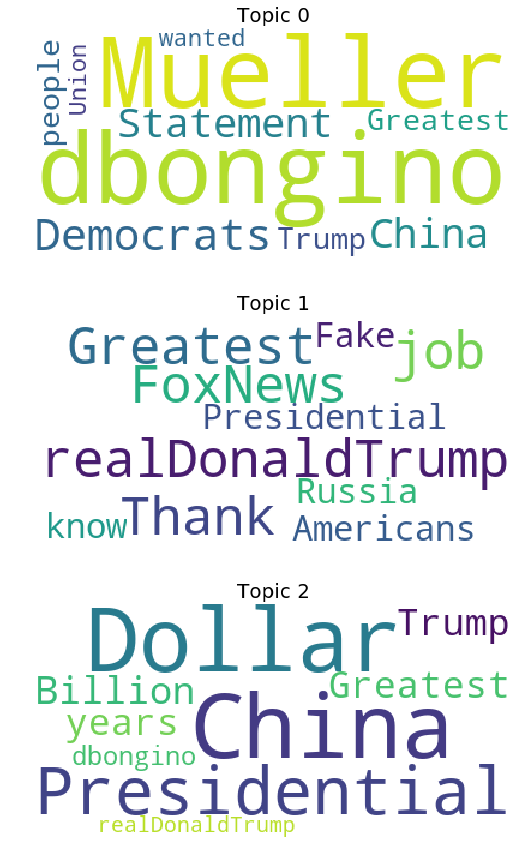

In [98]:
fig, axs = plt.subplots(num_topics)
fig.set_figheight(15)
fig.set_figwidth(15)

for i_topic in range(num_topics):
    text = ' '.join(w for w in recovered_df.iloc[:, i_topic])
    print('Topic {}: {}'.format(i_topic, text))
    wordCloud = WordCloud(background_color='white').generate(text)
    
    axs[i_topic].imshow(wordCloud)
    axs[i_topic].axis('off')
    axs[i_topic].set_title('Topic {}'.format(i_topic), size=20)